In [3]:
import os
import sys
from pathlib import Path
ASL = os.path.join(str(Path.home()), "ASL")
src = os.path.join(str(Path.home()), "ASL", "src")
sys.path.append(ASL)
sys.path.append(src)
os.chdir(ASL)
from utils_asl import load_yaml
from models_asl import FastSCNN
import torch

name = os.getenv("ENV_WORKSTATION_NAME")
env_cfg_path = os.path.join(ASL, f"cfg/env/{name}.yml")
exp_cfg_path = os.path.join(ASL, "cfg/exp/scannet_self_supervision/retrain_network/p_02/iteration_2_individual_replay02_scene_0.yml")

env = load_yaml(env_cfg_path)
exp = load_yaml(exp_cfg_path)

In [4]:
weights = {
    "pretrained": "scannet25k_24h_lr_decay_from_scratch/2021-06-05T14:36:26_scannet25k_24h_lr_decay_from_scratch/task0-epoch=64--step=158340.ckpt",
    "00_s0": "paper2/paper2/2021-09-14T09:17:23_s0_iteration2_r00/last.ckpt",
    "00_s1": "paper2/paper2/2021-09-14T09:17:21_s1_iteration2_r00/last.ckpt",
    "00_s2": "paper2/paper2/2021-09-14T09:17:23_s2_iteration2_r00/last.ckpt",
    "00_s3": "paper2/paper2/2021-09-14T09:17:28_s3_iteration2_r00/last.ckpt",
    "00_s4": "paper2/paper2/2021-09-14T09:17:21_s4_iteration2_r00/last.ckpt",
    "02_s0": "paper2/paper2/2021-09-14T09:20:24_s0_iteration2_r02/last.ckpt",
    "02_s1": "paper2/paper2/2021-09-14T09:20:22_s1_iteration2_r02/last.ckpt",
    "02_s2": "paper2/paper2/2021-09-14T09:20:24_s2_iteration2_r02/last.ckpt",
    "02_s3": "paper2/paper2/2021-09-14T09:20:24_s3_iteration2_r02/last.ckpt",
    "02_s4": "paper2/paper2/2021-09-14T09:20:24_s4_iteration2_r02/last.ckpt"
}

In [5]:
# Load model 
model = FastSCNN(**exp["model"]["cfg"])

In [6]:
# Generate Dataset 
from datasets_asl import adapter_tg_to_dataloader
from task import get_task_generator

adapter_tg_to_dataloader

# Task Generator
tg = get_task_generator(
name=exp["task_generator"].get("name", "scannet"),  # select correct TaskGenerator
mode=exp["task_generator"]["mode"],  # mode for TaskGenerator
cfg=exp["task_generator"]["cfg"],
)  # cfg for TaskGenerator
print(tg)

task_nr = 0
train_dataloader, val_dataloaders, task_name = adapter_tg_to_dataloader(
    tg, task_nr, exp["loader"], exp["replay"]["cfg_ensemble"], env
)

Summary TaskGenerator Tasks: 2
  00 Name: Train_25k 
  01 Name: Train_0 
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  4470 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/4470.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/4470.png 4470
Only do renanming


In [8]:
import copy
import numpy as np

class AccMonitor():
    def __init__(self):
        self.metrics = {}
        self.metric_dict = {'correct': 0,
                            'correct_valid': 0,
                            'correct_valid_both': 0,
                            'total': 0, 
                            'total_valid':0,
                            'total_valid_both':0,
                            'images': 0}
    def register(self,name):
        self.metrics[name] = copy.deepcopy(self.metric_dict)
        
    def update(self,name, label, gt):
        if name not in self.metrics.keys():
            self.register(name)
        m1 = gt != -1
        self.metrics[name]["total_valid"] += (m1).sum()
        self.metrics[name]["correct_valid"] += np.sum(gt[m1] == label[m1])
        
        m2 = (gt != -1 )*(label != -1)
        self.metrics[name]["total_valid_both"] += (m2).sum()
        self.metrics[name]["correct_valid_both"] += np.sum(gt[m2] == label[m2])
        
        self.metrics[name]["total"] += gt.size
        self.metrics[name]["correct"] += np.sum(gt == label)
        self.metrics[name]["images"] += 1
    
    def store_pickle(self, p):
        with open(p, 'wb') as handle:
            pickle.dump(self.metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def restore_pickle(self, p):
        with open(p, 'rb') as handle:
            self.metrics = pickle.load(handle)
            
    def __str__(self):
        s = "Acc-Monitor:\n"
        for k in self.metrics.keys():
            acc = self.metrics[k]['correct_valid'] / self.metrics[k]['total_valid']
            acc2 = self.metrics[k]['correct_valid_both'] / self.metrics[k]['total_valid_both']
            s += f"  {k}: Nr-Images: {self.metrics[k]['images']} , Avg-Acc: {acc}  Avg-Acc: valid both {acc2} \n"  
        return s
    

In [12]:
# EVALUATING PRETRAINING
def parse_batch(batch):
    ba = {}
    if len(batch) == 1:
      raise Exception("Dataloader is set to unique and not implemented")
    ba["images"] = batch[0]
    ba["label"] = batch[1]
    ba["replayed"] = batch[2]
    if len(batch) == 4:
      ba["ori_img"] = batch[3]
    if len(batch) == 5:
      ba["aux_label"] = batch[3]
      ba["aux_valid"] = batch[4]
    if len(batch) == 6:
      ba["aux_label"] = batch[3]
      ba["aux_valid"] = batch[4]
      ba["ori_img"] = batch[5]
    return ba

accm = AccMonitor() 
model.cuda()

for nr , k in enumerate( weights ):
    print(k)
    p = os.path.join(env["base"], weights[k])
    state_dict_loaded = torch.load(p, map_location=lambda storage, loc: storage)[
        "state_dict"
    ]
    # Filter state dict correctly
    state_dict_loaded = { k.replace("model.",""):v for (k,v) in state_dict_loaded.items() 
                         if k.find("_teacher") == -1 and k.find("_rssb") == -1 }
    res = model.load_state_dict(state_dict_loaded, strict=False)
    print(res)
    for i, batch in enumerate( val_dataloaders[0] ):
        if i % 50 == 0:
            print(i, len(val_dataloaders[0]))
        ba = parse_batch(batch)
        outputs = model(ba["images"].cuda())
        pred = torch.argmax(outputs[0], 1)
        BS = pred.shape[0]
        for j in range(BS):
            accm.update(k, pred.cpu().numpy()[j] ,ba["label"].numpy()[j])
    print( accm )

pretrained
<All keys matched successfully>
0 2437
50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
Acc-Monitor:
  pretrained: Nr-Images: 4874 , Avg-Acc: 0.4300264733611417  Avg-Acc: valid both 0.4300264733611417 

00_s0
<All keys matched successfully>
0 2437
50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
Acc-Monitor:
  pretrained: Nr-Images: 4874 , Avg-Acc: 0.4300264733611417  Avg-Acc: valid both 0.4300264733611417 
  00_s0: Nr-Images: 4874 , Avg-Acc: 0.3606075872242754  Avg-Acc: valid both 0.3606075872242754 
  00_s1: Nr-Images: 4874 , Avg-Acc: 0.3569321456231391  Avg-Acc: valid both 0.3569321456231391 
  00_s2: Nr-Images: 4874 , Avg-Acc: 0.3468667111532584  Avg-Acc: valid both 0.3468667111532584 
  00_s3: Nr-Images: 4874 , Avg-Acc: 0.27333545352360744  Avg-Acc: valid both 0.27333545352360744 
  00_s4: Nr-Images: 4874 , Avg-Acc: 0.24

In [ ]:
Image.open("filename")

In [28]:
def readImage(filename, H=640, W=1280, scale=True):
	img = Image.open(filename)
	return np.array( img )

# Read in ori res
i1 = readImage(p, H=640, W=1280, scale=False)
h, w, c = i1.shape
img = torch.nn.functional.interpolate(
  torch.from_numpy(i1.astype(np.float32))[None].permute(0, 3, 1, 2),
  (320, 640),
  mode="bilinear",
)[0].permute(1, 2, 0)

# Scale 320 X 640
img = (img / 255).permute(2, 0, 1)[None]
img = self.output_transform(img)

h, w, _ = readImage(pa[0], H=640, W=1280, scale=False).shape
pred, _ = fsh.model(img)
pred = F.softmax(pred, dim=1)
pred = torch.nn.functional.interpolate(pred, (h, w), mode="bilinear")
pred = pred.permute((0, 2, 3, 1))


{'scannet_auxilary_labels': {'label_setting': 'default'},
 'scannet_25k_individual': {'number_of_tasks': 1,
  'scenes_per_task': 1,
  'label_setting': 'labels_individual_scenes_map_2',
  'confidence_aux': 0.1,
  'start_scene': 0},
 'scannet_scenes': {'number_of_tasks': 4, 'scenes_per_task': 5},
 'copy_to_template': {'output_size': [320, 640], 'label_setting': 'default'}}

In [49]:
from torchvision import transforms as tf

def images_prep (imgs):
    output_transform = tf.Compose(
      [tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    imgs = torch.nn.functional.interpolate( imgs , (320, 640), mode="bilinear")
    for i in range(imgs.shape[0]):
        imgs[i] = output_transform( imgs[i] )

    return imgs

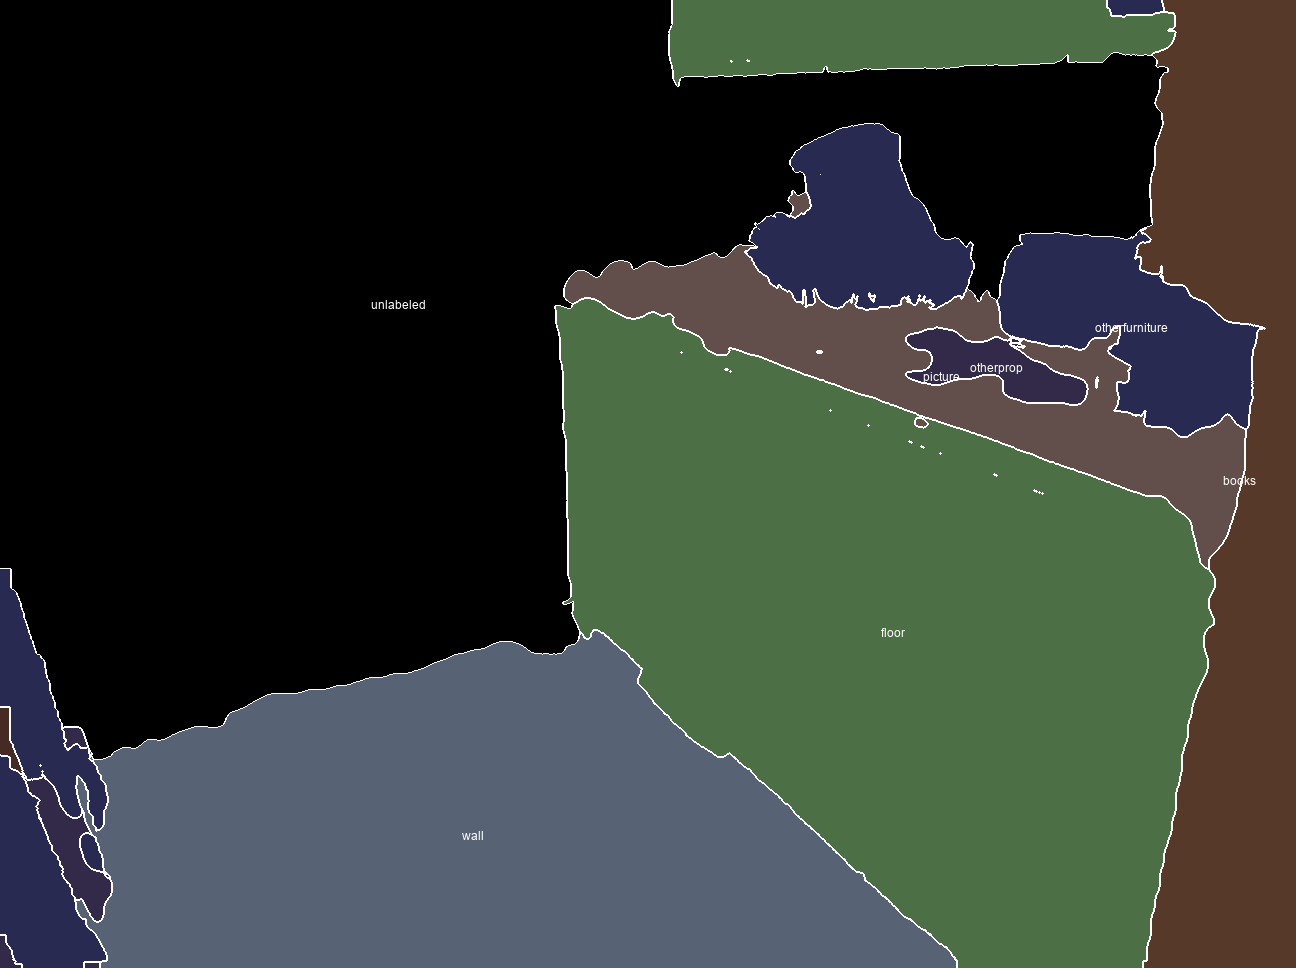

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]],

       ...,

       [[50, 42, 72],
        [50, 42, 72],
        [50, 42, 72],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]],

       [[50, 42, 72],
        [50, 42, 72],
        [50, 42, 72],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]],

       [[50, 42, 72],
        [50, 42, 72],
        [50, 42, 72],
        ...,
        [86, 57, 41],
        [86, 57, 41],
        [86, 57, 41]]], dtype=uint8)

In [78]:
np.uint8( (img_ori[j]* 255).permute(1,2,0).numpy()).shape ,ba["label"].numpy()[j].shape

visu.plot_detectron(np.zeros((968, 1296, 3) ), ba["label"].numpy()[j] , jupyter=True)

In [87]:
exp["loader"]

{'pin_memory': True, 'batch_size': 2, 'shuffle': True, 'num_workers': 0}

In [102]:
from visu import Visualizer
visu = Visualizer( p_visu= "/home/jonfrey/Pictures/test")  
accm_val = AccMonitor() 
model.cuda()
model.eval()
with torch.no_grad():
    for task_nr in [0,1,2,3,4]:
        exp["task_generator"]["cfg"]["copy_to_template"]['output_size'] = [968,1296]
        exp["task_generator"]["cfg"]['scannet_25k_individual']['start_scene'] = task_nr
        # Task Generator
        tg = get_task_generator(
            name=exp["task_generator"].get("name", "scannet"),  # select correct TaskGenerator
            mode=exp["task_generator"]["mode"],  # mode for TaskGenerator
            cfg=exp["task_generator"]["cfg"],
        )  # cfg for TaskGenerator

        train_dataloader, val_dataloaders, task_name = adapter_tg_to_dataloader(
            tg, 1, exp["loader"], exp["replay"]["cfg_ensemble"], env
        )
        val_dataloaders[1].dataset._output_trafo = None


        k = f"00_s{task_nr}"

        p = os.path.join(env["base"], weights[k])
        state_dict_loaded = torch.load(p, map_location=lambda storage, loc: storage)[
            "state_dict"
        ]
        # Filter state dict correctly
        state_dict_loaded = { k.replace("model.",""):v for (k,v) in state_dict_loaded.items() 
                             if k.find("_teacher") == -1 and k.find("_rssb") == -1 }
        res = model.load_state_dict(state_dict_loaded, strict=False)
        print(res)
        print("Start evaluating:", len( val_dataloaders[1] ) *2  )
        
        for nr in [0,1]:
            
            for i, batch in enumerate( val_dataloaders[nr] ):

                if i % 50 == 0:
                    print(i, len(val_dataloaders[nr]))

                ba = parse_batch( batch )
                img_ori = ba["images"].clone()
                imgs = images_prep (ba["images"])
                outputs = model(imgs.cuda())
                pred = torch.nn.functional.interpolate(outputs[0], (968,1296), mode="bilinear")
                pred = torch.argmax(pred, 1)
                BS = pred.shape[0]

                for j in range(BS):
                    if nr == 0:
                        kk = "gen_"
                    else:
                        kk = "ada_"
                    accm_val.update(kk+k, pred.cpu().numpy()[j] ,ba["label"].numpy()[j])

                #visu.plot_detectron( img_ori[j], ba["label"].numpy()[j]+1 , jupyter=True)
                #visu.plot_detectron( img_ori[j],pred.cpu().numpy()[j] +1 , jupyter=True)

print( accm_val )
    

LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  0 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/0.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/0.png 0
Only do renanming
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  4470 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/4470.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0000_00/labels_individual_scenes_map_2/4470.png 4470
Only do renanming
<All keys matched successfully>
Start evaluating: 352
0 2437


/home/jonfrey/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
0 176
50 176
100 176
150 176
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  17668 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0001_00/labels_individual_scenes_map_2/0.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0001_00/labels_individual_scenes_map_2/0.png 17668
Only do renanming
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_loca

/home/jonfrey/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
0 29
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  20500 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0002_00/labels_individual_scenes_map_2/0.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0002_00/labels_individual_scenes_map_2/0.png 20500
Only do renanming
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  24660 /home/jo

/home/jonfrey/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
0 125
50 125
100 125
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  32946 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0003_00/labels_individual_scenes_map_2/0.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0003_00/labels_individual_scenes_map_2/0.png 32946
Only do renanming
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]

/home/jonfrey/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
0 48
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  37700 /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0004_00/labels_individual_scenes_map_2/0.png
self.aux_label_pths[self.global_to_local_idx[0]] /home/jonfrey/Datasets/labels_generated/labels_individual_scenes_map_2/scans/scene0004_00/labels_individual_scenes_map_2/0.png 37700
Only do renanming
LABEL FILE DOSENT EXIST -> MAYBE ON JONAS LOCAL PC
Meethod  RGBA
self.global_to_local_idx[0]  38450 /home/jo

/home/jonfrey/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


50 2437
100 2437
150 2437
200 2437
250 2437
300 2437
350 2437
400 2437
450 2437
500 2437
550 2437
600 2437
650 2437
700 2437
750 2437
800 2437
850 2437
900 2437
950 2437
1000 2437
1050 2437
1100 2437
1150 2437
1200 2437
1250 2437
1300 2437
1350 2437
1400 2437
1450 2437
1500 2437
1550 2437
1600 2437
1650 2437
1700 2437
1750 2437
1800 2437
1850 2437
1900 2437
1950 2437
2000 2437
2050 2437
2100 2437
2150 2437
2200 2437
2250 2437
2300 2437
2350 2437
2400 2437
0 9
Acc-Monitor:
  gen_00_s0: Nr-Images: 4874 , Avg-Acc: 0.16865523839090057  Avg-Acc: valid both 0.16865523839090057 
  ada_00_s0: Nr-Images: 352 , Avg-Acc: 0.6845926759595794  Avg-Acc: valid both 0.6845926759595794 
  gen_00_s1: Nr-Images: 4874 , Avg-Acc: 0.09608056840550182  Avg-Acc: valid both 0.09608056840550182 
  ada_00_s1: Nr-Images: 57 , Avg-Acc: 0.4425646791941516  Avg-Acc: valid both 0.4425646791941516 
  gen_00_s2: Nr-Images: 4874 , Avg-Acc: 0.11424602319437374  Avg-Acc: valid both 0.11424602319437374 
  ada_00_s2: Nr-Imag

In [100]:
Acc-Monitor:
  gen_02_s0: Nr-Images: 4874 , Avg-Acc: 0.2488127639237661  Avg-Acc: valid both 0.2488127639237661 
  ada_02_s0: Nr-Images: 352 , Avg-Acc: 0.6778784234238061  Avg-Acc: valid both 0.6778784234238061 
  gen_02_s1: Nr-Images: 4874 , Avg-Acc: 0.13825980234904325  Avg-Acc: valid both 0.13825980234904325 
  ada_02_s1: Nr-Images: 57 , Avg-Acc: 0.5100196175779015  Avg-Acc: valid both 0.5100196175779015 
  gen_02_s2: Nr-Images: 4874 , Avg-Acc: 0.1464581316859022  Avg-Acc: valid both 0.1464581316859022 
  ada_02_s2: Nr-Images: 249 , Avg-Acc: 0.38491825721969786  Avg-Acc: valid both 0.38491825721969786 
  gen_02_s3: Nr-Images: 4874 , Avg-Acc: 0.12527829739128307  Avg-Acc: valid both 0.12527829739128307 
  ada_02_s3: Nr-Images: 96 , Avg-Acc: 0.7568598296630009  Avg-Acc: valid both 0.7568598296630009 
  gen_02_s4: Nr-Images: 4874 , Avg-Acc: 0.2421773265372228  Avg-Acc: valid both 0.2421773265372228 
  ada_02_s4: Nr-Images: 18 , Avg-Acc: 0.4206006984040598  Avg-Acc: valid both 0.4206006984040598 

'/home/jonfrey/Datasets/scannet/scans/scene0004_00/label-filt/920.png'

In [85]:
imgs.min()

tensor(-2.0323)

torch.Size([2, 968, 1296])

In [27]:
m00 = 0
for m in accm.metrics.keys():
    if m.find("00") != -1:
        res = np.round( accm.metrics[m]['correct_valid'] / accm.metrics[m]['total_valid'] * 100,1)
        print(  res ) 
        m00 += res
print("AVG", m00/5)
m02 = 0
for m in accm.metrics.keys():
    if m.find("02") != -1:
        res = np.round(accm.metrics[m]['correct_valid'] / accm.metrics[m]['total_valid']* 100,1)
        print(  res )
        m02 += res
print("AVG", m02/5)

su = 0       
for m in accm.metrics.keys():
    if m.find("00") != -1:
        res = np.round( ((accm.metrics[m]['correct_valid'] / accm.metrics[m]['total_valid']) -
                           accm.metrics[m.replace("00","02")]['correct_valid'] / accm.metrics[m.replace("00","02")]['total_valid'] ) * 100,1)
        print(  res) 
        su += res
print("ACG", su/5)    

36.1
35.7
34.7
27.3
24.5
AVG 31.660000000000004
37.6
37.2
36.3
31.8
32.4
AVG 35.06
-1.6
-1.5
-1.6
-4.5
-7.9
ACG -3.4200000000000004


In [91]:
Acc-Monitor:
  pretrained: Nr-Images: 4874 , Avg-Acc: 0.4300264733611417  Avg-Acc: valid both 0.4300264733611417 
  00_s0: Nr-Images: 4874 , Avg-Acc: 0.3606075872242754  Avg-Acc: valid both 0.3606075872242754 
  00_s1: Nr-Images: 4874 , Avg-Acc: 0.3569321456231391  Avg-Acc: valid both 0.3569321456231391 
  00_s2: Nr-Images: 4874 , Avg-Acc: 0.3468667111532584  Avg-Acc: valid both 0.3468667111532584 
  00_s3: Nr-Images: 4874 , Avg-Acc: 0.27333545352360744  Avg-Acc: valid both 0.27333545352360744 
  00_s4: Nr-Images: 4874 , Avg-Acc: 0.24491434752411298  Avg-Acc: valid both 0.24491434752411298 
  02_s0: Nr-Images: 4874 , Avg-Acc: 0.3764148426522724  Avg-Acc: valid both 0.3764148426522724 
  02_s1: Nr-Images: 4874 , Avg-Acc: 0.37181789596306963  Avg-Acc: valid both 0.37181789596306963 
  02_s2: Nr-Images: 4874 , Avg-Acc: 0.3633623971710632  Avg-Acc: valid both 0.3633623971710632 
  02_s3: Nr-Images: 4874 , Avg-Acc: 0.31847367948863775  Avg-Acc: valid both 0.31847367948863775 
  02_s4: Nr-Images: 4874 , Avg-Acc: 0.324270891168885  Avg-Acc: valid both 0.324270891168885

Acc-Monitor:
  00_s1: Nr-Images: 4874 , Avg-Acc: 0.3545160250173662  Avg-Acc: valid both 0.3545160250173662 
  00_s2: Nr-Images: 4874 , Avg-Acc: 0.32887771248036635  Avg-Acc: valid both 0.32887771248036635 
  00_s3: Nr-Images: 4874 , Avg-Acc: 0.2689870979555444  Avg-Acc: valid both 0.2689870979555444 
  00_s4: Nr-Images: 4874 , Avg-Acc: 0.22900319048406723  Avg-Acc: valid both 0.22900319048406723 

